# Data Intake

In [ ]:
import itertools
import nltk
import numpy as np
import pandas as pd
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_json('/content/drive/MyDrive/NLP PROJECT/dataset_es_train.json',lines= True)

In [ ]:
#data= pd.read_json('C://Users//nacho//repositorios//Acamica//data//dataset_es_train.json',lines= True)

In [ ]:
print(data.shape)
data.head()

(200000, 8)


,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


### **Objetivo:**

Implementar un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente.

# 1- EDA

### **Ideas**

**Real Drivers**:
1. Tiempo
2. Calidad
3. Expectativas defraudas

**BrainStorming:**

1.   Algunos comentarios tienen algunas esperanzas futuras - Puntuan previamente a la puntuación real
2.   Emojis
3. Que hacer con jergas españolas (¿La pata de la cabra?)



**Averiguar:**

1- Como es el proceso de opinión - ¿Lead time?

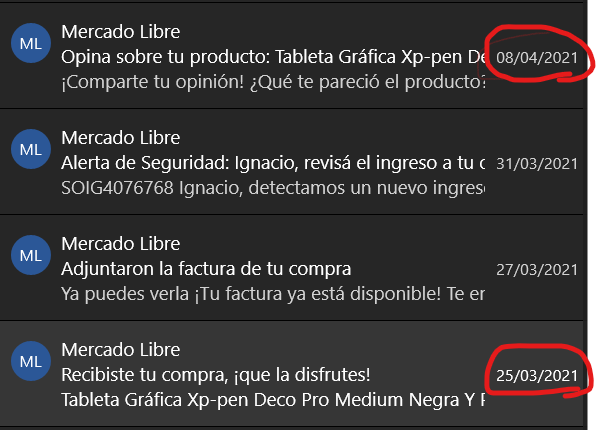

Funciones:



1- NPS

2- Call center = Speech to text-> input de este modelo

3- Brand/Social Media monitoring

4- Market Research =  Recolección de insight a través del estudio de comentarios de clientes acerca de campañas para verificar que tal está funcionando en tiempo real. (Por ejemplo desd twitter) Tambien puede servir como un feedback (masivo) instantaneo del lanzamiento de un producto.

5- Cuantificar opiniones en tiempo real: por ejemplo para automatizar operaciones de trading

### **Data Understanding**

In [ ]:
print('Columns ' , data.columns)
print('Sahpe ', data.shape)
print('Data Types:  ',data.dtypes)

Columns  Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')
Sahpe  (200000, 8)
Data Types:   review_id           object
product_id          object
reviewer_id         object
stars                int64
review_body         object
review_title        object
language            object
product_category    object
dtype: object


In [ ]:
data.describe(include='all')

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
count,200000,200000,200000,200000.000000,200000,200000,200000,200000
unique,200000,150938,179076,NaN,198264,112114,1,30
top,es_0353251,product_es_0261843,reviewer_es_0437514,NaN,Buena relación calidad precio,Bien,es,home
freq,1,8,7,NaN,106,1952,200000,26962
mean,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1.414217,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN


**1- Review_id :** son 200.000 instancias diferentes, por lo que podríamos eliminarla. Habría que investigar si la notación utilizada tiene alguna temporalidad.

In [ ]:
#Review_id
data.review_id.nunique()

200000

**2- Product_id:** Tenemos 150.938 instancias diferentes.

In [ ]:
#Product_id
data.product_id.nunique()

150938

In [ ]:
frecuencia = data.product_id.value_counts().to_frame('f')
frecuencia['f']= frecuencia['f'].astype(int)
frecuencia=frecuencia.value_counts().to_frame('q')
frecuencia['q']= np.log10(frecuencia['q'])
frecuencia = frecuencia.reset_index()
frecuencia

,f,q
0,1,5.052694
1,2,4.466274
2,3,3.841672
3,4,3.170555
4,5,2.484300
5,6,1.531479
6,7,1.079181
7,8,0.000000


Text(17.175000000000004, 0.5, 'Log(X)')

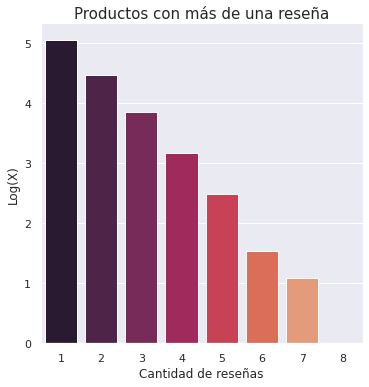

In [ ]:
sns.catplot( x=frecuencia.f, y=frecuencia.q, data=frecuencia, palette='rocket',kind='bar')
plt.title('Productos con más de una reseña',fontsize=15)
plt.xlabel('Cantidad de reseñas')
plt.ylabel('Log(X)')

pendiente = hacer gráfico de productos con mas de una review

In [ ]:
frecuencia.value_counts()

f  q       
8  0.000000    1
7  1.079181    1
6  1.531479    1
5  2.484300    1
4  3.170555    1
3  3.841672    1
2  4.466274    1
1  5.052694    1
dtype: int64

**3- Reviewer_id :** al igual que en product_id tenemos muchas instancias de un solo comentario ( 179.076) pero también tenemos gente que ha opinado hasta 7 veces

In [ ]:
data.reviewer_id.nunique()

179076

**4 - Stars:** El target de nuestro modelo. Está perfectamente balanceado-

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 6.799999999999979, 'Estrellas')

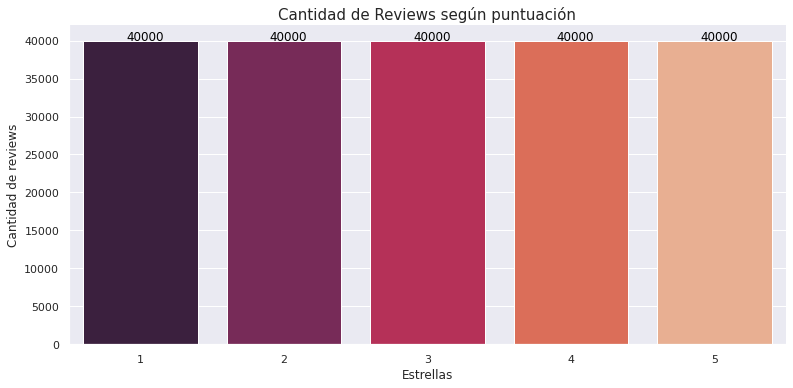

In [ ]:
g=sns.catplot(data.stars.value_counts().index,
              data.groupby('stars').review_id.agg('count'),
              data=data,kind='bar',palette = 'rocket',
              height=5, aspect=18/8.27)

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.3, 
            p.get_height() * 1, 
            "{:.0f}".format(p.get_height()), 
            color='black', rotation='horizontal', size='large')
plt.title('Cantidad de Reviews según puntuación',fontsize=15)
plt.ylabel('Cantidad de reviews')
plt.xlabel('Estrellas')

In [ ]:
data.stars.isna().sum()

0

No hay faltantes en nuestro target

**6- Review Title**

Quizás la cosa va por aquí...

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Bien'),
  Text(1, 0, 'Perfecto'),
  Text(2, 0, 'Buen producto'),
  Text(3, 0, 'Regular'),
  Text(4, 0, 'Buena compra'),
  Text(5, 0, 'Mala calidad'),
  Text(6, 0, 'Genial'),
  Text(7, 0, 'Correcto'),
  Text(8, 0, 'Buena calidad'),
  Text(9, 0, 'Bueno'),
  Text(10, 0, 'Muy bien'),
  Text(11, 0, 'Recomendable'),
  Text(12, 0, 'No funciona'),
  Text(13, 0, 'No lo recomiendo'),
  Text(14, 0, 'Muy bueno')])

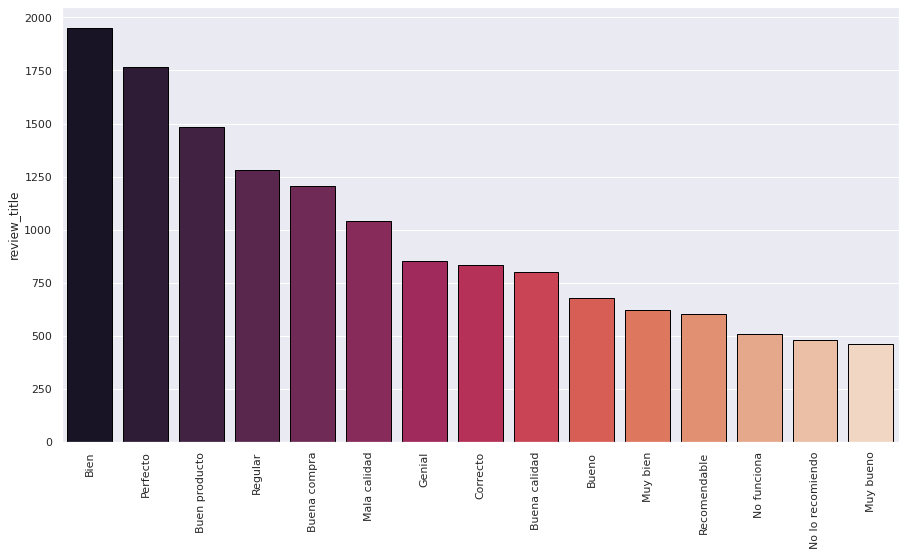

In [ ]:
plt.figure(figsize = (15,8))
sns.barplot(x =data.review_title.value_counts().iloc[:15].index,
                   y=  data.review_title.value_counts().iloc[:15],
                   data = data,palette = 'rocket', edgecolor ='black')
plt.xticks(rotation=90)

In [ ]:
print(data[(data['review_title']== 'Bien') & (data['stars']==5)].shape[0])
print(data[(data['review_title']== 'Bien') & (data['stars']==4)].shape[0])
print(data[(data['review_title']== 'Bien') & (data['stars']==3)].shape[0])
print(data[(data['review_title']== 'Bien') & (data['stars']==2)].shape[0])
print(data[(data['review_title']== 'Bien') & (data['stars']==1)].shape[0])

287
869
701
78
17


La cosa no es por aca...

**8- Product_category**

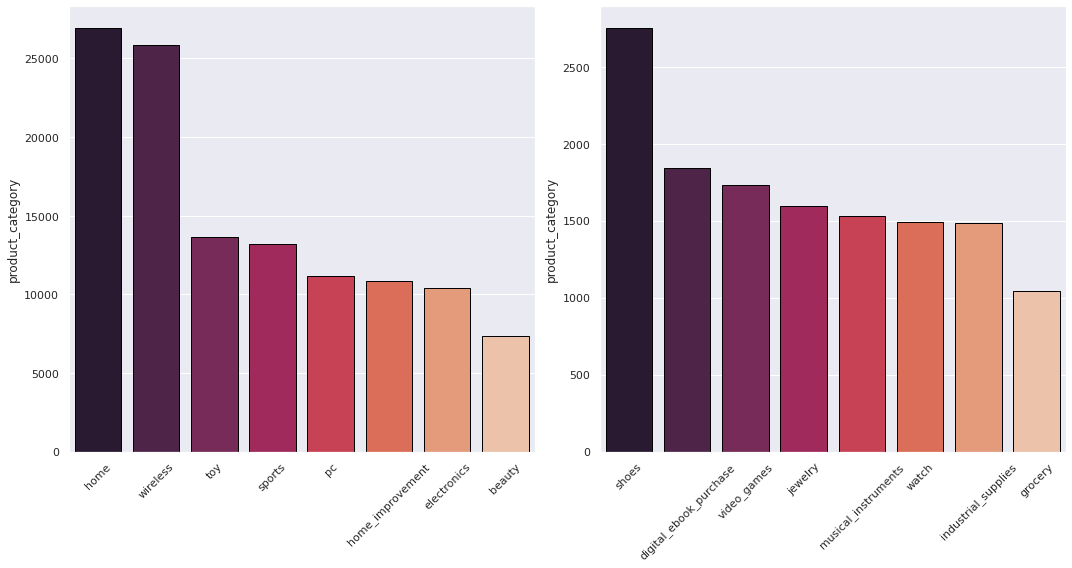

In [ ]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
sns.barplot(x =data.product_category.value_counts().iloc[:8].index,
                   y=  data.product_category.value_counts().iloc[:8],
                   data = data,palette = 'rocket', edgecolor ='black')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(x =data.product_category.value_counts().iloc[-8:].index,
                   y=  data.product_category.value_counts().iloc[-8:],
                   data = data,palette = 'rocket', edgecolor ='black')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### **Exploración del dataset**

In [ ]:
index_random = np.random.randint(0,high = data.shape[0])
comentario = data.iloc[index_random].review_body
estrella =  data.iloc[index_random].stars
titulo = data.iloc[index_random].review_title
categoria = data.iloc[index_random].product_category
print(index_random)
print(estrella)
print(categoria)
print(titulo)
print(comentario)

119050
3
lawn_and_garden
Funciona, pero no es perfecto
Cumple su misión, pero se ve claramente que no es de una gran calidad. Las mediciones de temperatura son correctas y las de humedad me dan una diferencia de un 10% con una estación oregon scientific colocada a su lado para testarlo. Las 3 estrellas son debidas a esa falta de precisión, a la construcción, que si bien es muy aparente se ve que es de plástico bastante endeble, no pesa nada. Por el precio que tiene no se puede pedir mucho más.


In [ ]:
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

**sent_tokenize** 

In [ ]:
comentario_st = nltk.tokenize.sent_tokenize(comentario)
comentario_st

['Cumple su misión, pero se ve claramente que no es de una gran calidad.',
 'Las mediciones de temperatura son correctas y las de humedad me dan una diferencia de un 10% con una estación oregon scientific colocada a su lado para testarlo.',
 'Las 3 estrellas son debidas a esa falta de precisión, a la construcción, que si bien es muy aparente se ve que es de plástico bastante endeble, no pesa nada.',
 'Por el precio que tiene no se puede pedir mucho más.']

word_tokenize

In [ ]:
comentario_wt = nltk.tokenize.word_tokenize(comentario)
comentario_wt

['Cumple',
 'su',
 'misión',
 ',',
 'pero',
 'se',
 've',
 'claramente',
 'que',
 'no',
 'es',
 'de',
 'una',
 'gran',
 'calidad',
 '.',
 'Las',
 'mediciones',
 'de',
 'temperatura',
 'son',
 'correctas',
 'y',
 'las',
 'de',
 'humedad',
 'me',
 'dan',
 'una',
 'diferencia',
 'de',
 'un',
 '10',
 '%',
 'con',
 'una',
 'estación',
 'oregon',
 'scientific',
 'colocada',
 'a',
 'su',
 'lado',
 'para',
 'testarlo',
 '.',
 'Las',
 '3',
 'estrellas',
 'son',
 'debidas',
 'a',
 'esa',
 'falta',
 'de',
 'precisión',
 ',',
 'a',
 'la',
 'construcción',
 ',',
 'que',
 'si',
 'bien',
 'es',
 'muy',
 'aparente',
 'se',
 've',
 'que',
 'es',
 'de',
 'plástico',
 'bastante',
 'endeble',
 ',',
 'no',
 'pesa',
 'nada',
 '.',
 'Por',
 'el',
 'precio',
 'que',
 'tiene',
 'no',
 'se',
 'puede',
 'pedir',
 'mucho',
 'más',
 '.']

Detalles: 
Word tokenizing nos separa:
- (
- .
- -

## Basic Feature Extraction

Primero, analicemos cuantas palabras hay en cada comentario, y veamos cual es el promedio de palabras por estrella. Puede que sea un buen feature para el modelo.

In [ ]:
df1= pd.concat([data.review_body,data.stars],axis=1)

In [ ]:
df1['word_count'] = df1['review_body'].apply(lambda x: len(str(x).split(" ")))
df1.head()

,review_body,stars,word_count
0,Nada bueno se me fue ka pantalla en menos de 8...,1,19
1,"Horrible, nos tuvimos que comprar otro porque ...",1,23
2,Te obligan a comprar dos unidades y te llega s...,1,22
3,"No entro en descalificar al vendedor, solo pue...",1,60
4,Llega tarde y co la talla equivocada,1,7


In [ ]:
print('Promdio de Palabras para comentarios con 1 estrella = ',df1.loc[df1.stars == 1].word_count.mean())
print('Promdio de Palabras para comentarios con 2 estrella = ',df1.loc[df1.stars == 2].word_count.mean())
print('Promdio de Palabras para comentarios con 3 estrella = ',df1.loc[df1.stars == 3].word_count.mean())
print('Promdio de Palabras para comentarios con 4 estrella = ',df1.loc[df1.stars == 4].word_count.mean())
print('Promdio de Palabras para comentarios con 5 estrella = ',df1.loc[df1.stars == 5].word_count.mean())

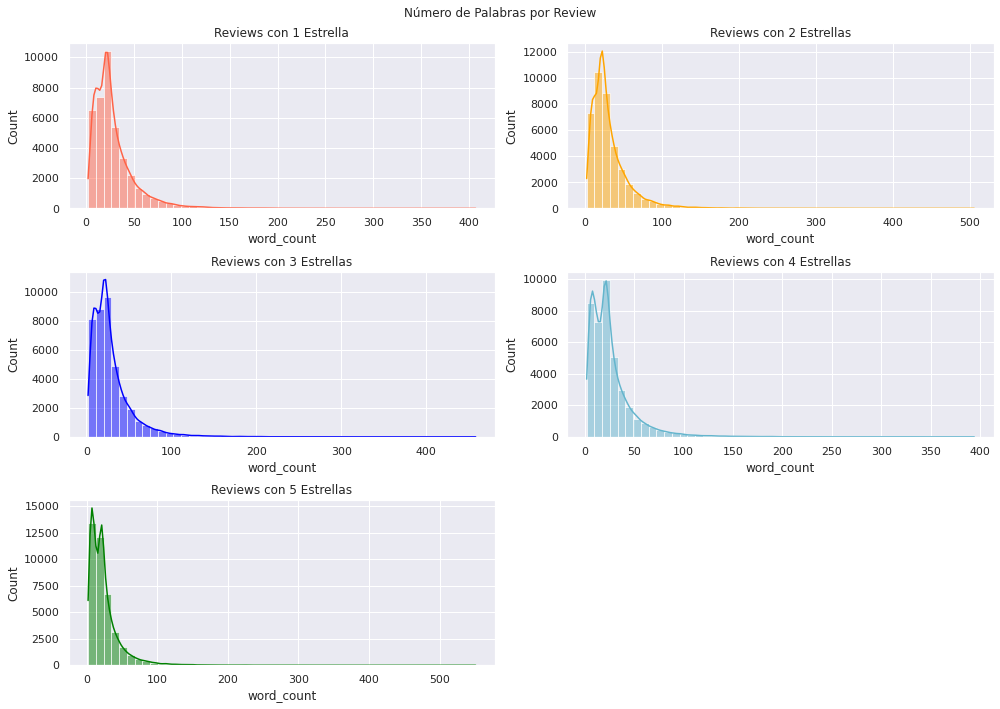

In [ ]:
fig,axes = plt.subplots(3,2,figsize=(14,10))
axes = axes.flatten()

data_1_star = df1[df1['stars']==1]
sns.histplot(ax = axes[0], data= data_1_star, x ='word_count', color= 'tomato', bins = 50, kde=True)
axes[0].set_title('Reviews con 1 Estrella')

data_2_star = df1[df1['stars']==2]
sns.histplot(ax = axes[1], data= data_2_star, x ='word_count', color= 'orange', bins = 50, kde=True)
axes[1].set_title('Reviews con 2 Estrellas')

data_3_star = df1[df1['stars']==3]
sns.histplot(ax = axes[2], data= data_3_star, x ='word_count', color= 'blue', bins = 50, kde=True)
axes[2].set_title('Reviews con 3 Estrellas')

data_4_star = df1[df1['stars']==4]
sns.histplot(ax = axes[3], data= data_4_star, x ='word_count', color= 'c', bins = 50, kde=True)
axes[3].set_title('Reviews con 4 Estrellas')

data_5_star = df1[df1['stars']==5]
sns.histplot(ax = axes[4], data=data_5_star, x='word_count', color= 'green', bins = 50, kde=True)
axes[4].set_title('Reviews con 5 Estrellas')

# Se eliminan los axes vacios
for i in [5]:
    fig.delaxes(axes[i])
    
fig.suptitle('Número de Palabras por Review')
plt.tight_layout()
plt.show()

In [ ]:
!pip install contexto
#pip install stanza
#pip install torch torchvision

In [ ]:
from contexto.exploracion import grafica_barchart_frecuencias, obtener_ngramas, nube_palabras
# Se crea una variable 'texto' que nos permite juntar el texto de todas las reviews en uno solo
texto = ' '.join(data['review_body'])
#texto
# Con la función obtener_ngramas se obtienen las listas de unigramas, bigramas y trigramas
unigramas = obtener_ngramas(texto, 1)
bigramas = obtener_ngramas(texto, 2)
trigramas = obtener_ngramas(texto, 3)

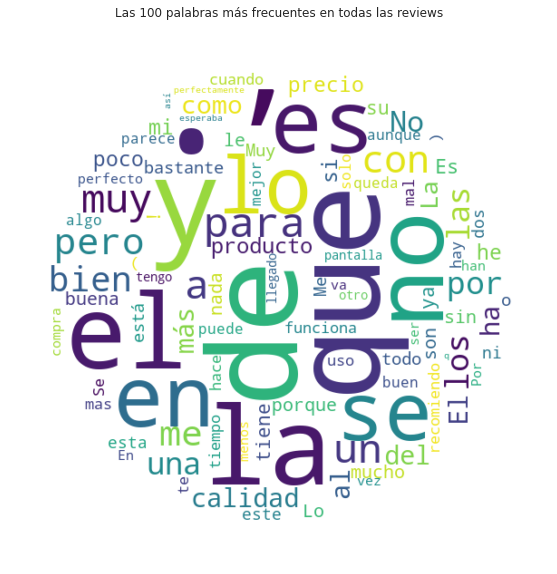

In [ ]:
nube_palabras(texto, n_grama=1, titulo='Las 100 palabras más frecuentes en todas las reviews', dim_figura=(10,10))

# 2 - Normalización

### Funciones


1- Función de limpieza de RegEx

In [ ]:
import re
import string

def clean_text_round1(text):
   text = text.lower()
   text = re.sub('\[.*?¿\]\%', ' ', text)
   text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
   text = re.sub('\w*\d\w*', '', text)
   text = re.sub('[‘’“”…«»]', '', text)
   text = re.sub('\n', ' ', text)
   return text

Funciones de Fede

In [ ]:
def basic_text_cleanup(text):
    """
    Convert to lowercase, remove punctuation, remove digits
    """
    text = text.lower() #lower case
    text = re.sub("[^\w|\s]", " ",text) #replace non word and non space characters by a space
    text = re.sub("\s+", " ",text) #remove extra spaces
    text = re.sub("á", "a",text) #saco acentos
    text = re.sub("é", "e",text) #saco acentos
    text = re.sub("í", "i",text) #saco acentos
    text = re.sub("ó", "o",text) #saco acentos
    text = re.sub("ú", "u",text) #saco acentos
    text = re.sub(",", "",text) #saco comas
    #doc = nlp(text)#convert to a spacy object
    #doc = [w.text for w in doc if not w.is_stop or w.text =="no"] # remove stopwords but keep "no" for bigrams
    #doc = [w for w in doc if (len(w)> 2 or w == "no")] #only words longer than 2 characters
    #doc = [w for w in doc if (len(w)> 2 )] #only words longer than 2 characters
    #doc = [w for w in doc if w != "y"] #remove "y"
    #doc = " ".join(doc)
    return text


In [ ]:
#Como aplico lo de arriba? 
data["clean_text"] = data["review_body"].apply(lambda x:basic_text_cleanup(x) )


In [ ]:
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize

STOP_WORDS = stopwords.words('spanish')

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

df["token"] = df["normal"].apply(lambda x:tokenize(x))


2- Función de limpieza de emojis

In [ ]:
#Eliminamos los emojis de los comentarios. Tale como 😜 , 😔 , etc.
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

3- Función de limpieza de emoticones

In [ ]:
!pip install emot


In [ ]:
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

# Remover emoticones tales como :-) , :'( , etc
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

## Introducción

In [ ]:
comentario

'Lo único es que se desplazan mucho... Peor es normal solo tienen el broche no una cinta adhesiva...'

In [ ]:
comentario=clean_text_round1(comentario)
comentario

'lo único es que se desplazan mucho    peor es normal solo tienen el broche no una cinta adhesiva   '

In [ ]:
index_random = np.random.randint(0,high = data.shape[0])
comentario = data.iloc[index_random].review_body
estrella =  data.iloc[index_random].stars
titulo = data.iloc[index_random].review_title
categoria = data.iloc[index_random].product_category
print(index_random)
print(estrella)
print(categoria)
print(titulo)
print(comentario)

168960
5
home_improvement
Muy funcional
Mi novio necesitaba uno de estos para su trabajo y me decidi a comprarle este por los comentarios y el precio. El esta encantado dice que le funciona genial asi que por mi parte estoy satisfecha con mi compra


### **StopWords**

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('spanish')) 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print("Lista de stopwords en español:")

print(stopwords)

Lista de stopwords en español:
{'le', 'tengáis', 'hube', 'contra', 'estos', 'estando', 'tengas', 'tuyo', 'hubieseis', 'cual', 'quienes', 'habidos', 'qué', 'haya', 'estabais', 'eran', 'fuera', 'ante', 'otros', 'nuestras', 'algunos', 'habíamos', 'esos', 'nuestro', 'tus', 'este', 'habríamos', 'teníamos', 'también', 'serían', 'mío', 'nuestros', 'suyas', 'ese', 'esas', 'habrías', 'sentidos', 'era', 'te', 'estarás', 'tuyas', 'habría', 'suyo', 'vuestra', 'quien', 'tened', 'al', 'tuviesen', 'del', 'poco', 'ti', 'pero', 'estuvo', 'teniendo', 'tuve', 'tuviese', 'sus', 'hayan', 'vuestro', 'sí', 'mi', 'son', 'tendría', 'hubisteis', 'otras', 'o', 'estuvieron', 'habéis', 'ellas', 'sois', 'hubieran', 'sentida', 'tuvo', 'e', 'estamos', 'habréis', 'él', 'de', 'fui', 'los', 'tenías', 'tu', 'eres', 'habías', 'han', 'ellos', 'estado', 'ni', 'hay', 'seremos', 'hubieses', 'está', 'estuvisteis', 'fuerais', 'me', 'estas', 'estaríais', 'habidas', 'tendrías', 'hubiste', 'he', 'más', 'estadas', 'tenido', 'tengam

In [ ]:
comentario_wt = nltk.tokenize.word_tokenize(comentario)
comentario_wt

['Mi',
 'novio',
 'necesitaba',
 'uno',
 'de',
 'estos',
 'para',
 'su',
 'trabajo',
 'y',
 'me',
 'decidi',
 'a',
 'comprarle',
 'este',
 'por',
 'los',
 'comentarios',
 'y',
 'el',
 'precio',
 '.',
 'El',
 'esta',
 'encantado',
 'dice',
 'que',
 'le',
 'funciona',
 'genial',
 'asi',
 'que',
 'por',
 'mi',
 'parte',
 'estoy',
 'satisfecha',
 'con',
 'mi',
 'compra']

In [ ]:
comentario_sin_sw = [i for i in comentario_wt if i not in stopwords]
comentario_sin_sw

['Mi',
 'novio',
 'necesitaba',
 'trabajo',
 'decidi',
 'comprarle',
 'comentarios',
 'precio',
 '.',
 'El',
 'encantado',
 'dice',
 'funciona',
 'genial',
 'asi',
 'parte',
 'satisfecha',
 'compra']

### **Frecuencia**

In [ ]:
freq = nltk.FreqDist(comentario_sin_sw)
freq

FreqDist({'.': 1,
          'El': 1,
          'Mi': 1,
          'asi': 1,
          'comentarios': 1,
          'compra': 1,
          'comprarle': 1,
          'decidi': 1,
          'dice': 1,
          'encantado': 1,
          'funciona': 1,
          'genial': 1,
          'necesitaba': 1,
          'novio': 1,
          'parte': 1,
          'precio': 1,
          'satisfecha': 1,
          'trabajo': 1})

## **Filtración y análisis de frecuencias**

### 1- Dataset con los comentarios positivos ( de 4 y 5 estrellas)

In [ ]:
#Saco palabras que no aportan un gran valor semánitico
filtrar = ['es','el','muy','la','los','lo','me','si','no','se']

In [ ]:
positivo = data[data.stars > 3]
positivo.shape

(80000, 8)

In [ ]:
resenas = []
for i in range(positivo.shape[0]):
  comentario = positivo.iloc[i].review_body
  comentario = clean_text_round1(comentario)
  comentario = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(comentario)
  comentario = [word for word in comentario if word not in stopwords]
  comentario = [word for word in comentario if word not in filtrar]

  resenas.append(comentario)

In [ ]:
resenas = list(itertools.chain(*resenas))
resenas[0:10]

['buena',
 'pinta',
 'veremos',
 'resultado',
 'entrega',
 'rápida',
 'siempre',
 'falta',
 'factura',
 'bien']

In [ ]:
freq_positivo = nltk.FreqDist(resenas)
freq_positivo

FreqDist({'buena': 13130,
          'pinta': 353,
          'veremos': 239,
          'resultado': 804,
          'entrega': 1532,
          'rápida': 761,
          'siempre': 1533,
          'falta': 1078,
          'factura': 83,
          'bien': 23539,
          'envío': 1659,
          'rápido': 3004,
          'queda': 3133,
          'material': 1788,
          'duradero': 198,
          'tamaño': 2923,
          'perfecto': 7368,
          'genial': 3655,
          'aunque': 3916,
          'huele': 305,
          'pegamento': 144,
          'llega': 403,
          'eliminar': 62,
          'todas': 1162,
          'manchas': 98,
          'espera': 201,
          'calidad': 15739,
          'plástico': 1214,
          'regulero': 4,
          'parece': 3019,
          'q': 1808,
          'va': 3408,
          'romper': 94,
          'rajar': 2,
          'enseguida': 265,
          'demás': 1568,
          'fácil': 4478,
          'instalación': 436,
          'funciona': 43

In [ ]:
palabras_positivas = pd.DataFrame(list(freq_positivo.items()),columns=['Palabra','Frecuencia'])
palabras_positivas.sort_values('Frecuencia',ascending=False, inplace = True)
palabras_positivas.reset_index(drop = True, inplace=True)
palabras_positivas.head()

,Palabra,Frecuencia
0,bien,23539
1,calidad,15739
2,buena,13130
3,precio,12876
4,producto,8791


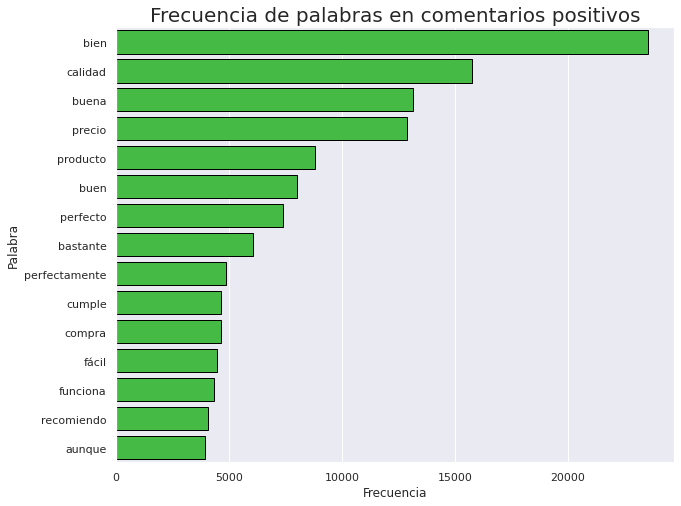

In [ ]:
plt.figure(figsize = (10,8))
plot = sns.barplot(y  = palabras_positivas.iloc[:15].Palabra, 
                   x = palabras_positivas.iloc[:15].Frecuencia ,
                   color = 'limegreen', edgecolor ='black' )
for item in plot.get_yticklabels():
    item.set_rotation(0)
plt.title('Frecuencia de palabras en comentarios positivos',fontsize = 20)
plt.show()

### 2- Dataset con los comentarios neutros( 3 estrellas)

In [ ]:
neutro = data[data.stars ==3]
neutro.shape  

(40000, 8)

In [ ]:
resenas = []
for i in range(neutro.shape[0]):
  comentario = neutro.iloc[i].review_body
  comentario = clean_text_round1(comentario)
  comentario = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(comentario)
  comentario = [word for word in comentario if word not in stopwords]
  comentario = [word for word in comentario if word not in filtrar]
  resenas.append(comentario)

In [ ]:
resenas = list(itertools.chain(*resenas))
resenas[0:10]

['cabe',
 'bien',
 'móvil',
 'cumple',
 'función',
 'hecha',
 'menos',
 'pequeño',
 'espacio',
 'guardar']

In [ ]:
freq_neutro = nltk.FreqDist(resenas)
freq_neutro

FreqDist({'cabe': 176,
          'bien': 13948,
          'móvil': 758,
          'cumple': 1864,
          'función': 1527,
          'hecha': 73,
          'menos': 1741,
          'pequeño': 1538,
          'espacio': 277,
          'guardar': 162,
          'tarjeta': 107,
          'efectivo': 68,
          'seria': 133,
          'útil': 396,
          'aparato': 278,
          'tamaño': 1223,
          'perfecto': 1023,
          'embocadura': 1,
          'suficientemente': 76,
          'grande': 1633,
          'poner': 1016,
          'verduras': 18,
          'comodidad': 108,
          'compré': 994,
          'electrodoméstico': 2,
          'hacer': 976,
          'tortillas': 3,
          'patatas': 20,
          'resultó': 34,
          'ideal': 209,
          'cebollas': 3,
          'quedan': 533,
          'trituradas': 1,
          'mas': 2588,
          'salé': 1,
          'busco': 10,
          'salen': 208,
          'curvas': 14,
          'luces': 165,
      

In [ ]:
palabras_neutras = pd.DataFrame(list(freq_neutro.items()),columns=['Palabra','Frecuencia'])
palabras_neutras.sort_values('Frecuencia',ascending=False, inplace = True)
palabras_neutras.reset_index(drop = True, inplace=True)
palabras_neutras.head()

,Palabra,Frecuencia
0,bien,13948
1,calidad,5969
2,precio,5378
3,producto,3973
4,bastante,3299


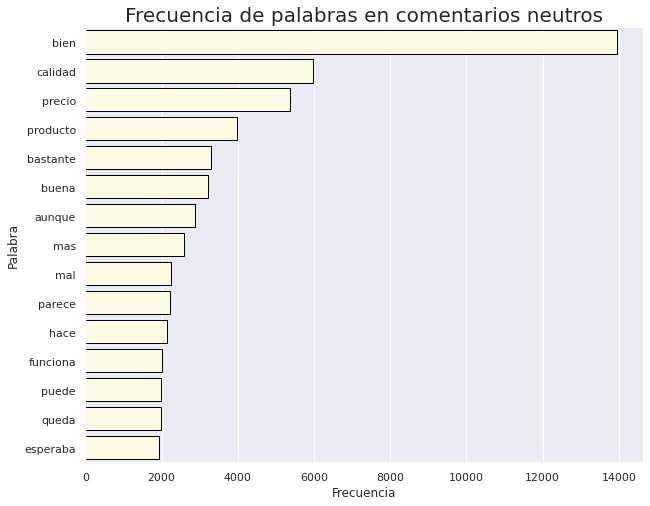

In [ ]:

plt.figure(figsize = (10,8))
plot = sns.barplot(y  = palabras_neutras.iloc[:15].Palabra,
                   x = palabras_neutras.iloc[:15].Frecuencia ,
                   color = 'lightyellow', edgecolor ='black' )
for item in plot.get_xticklabels():
    item.set_rotation(0)
plt.title('Frecuencia de palabras en comentarios neutros', fontsize=20)
plt.show()


Palabras en común con Positivo:
 
 1. Bien
 2. El 
 3. No
 4. calidad
 5. si 
 

### 3- Dataset con los comentarios negativos( 1 y 2 estrellas)

In [ ]:
negativo = data[data.stars < 3]
negativo.shape

(80000, 8)

In [ ]:
resenas = []
for i in range(negativo.shape[0]):
  comentario = negativo.iloc[i].review_body
  comentario = clean_text_round1(comentario)
  comentario = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(comentario)
  comentario = [word for word in comentario if word not in stopwords]
  comentario = [word for word in comentario if word not in filtrar]
  resenas.append(comentario)

In [ ]:
resenas = list(itertools.chain(*resenas))
resenas[0:10]

['bueno',
 'ka',
 'pantalla',
 'menos',
 'meses',
 'recibido',
 'respuesta',
 'fabricante',
 'horrible',
 'comprar']

In [ ]:
freq_negativo = nltk.FreqDist(resenas)
freq_negativo

FreqDist({'bueno': 1905,
          'ka': 11,
          'pantalla': 3806,
          'menos': 3530,
          'meses': 3409,
          'recibido': 2232,
          'respuesta': 573,
          'fabricante': 365,
          'horrible': 401,
          'comprar': 3385,
          'sabemos': 46,
          'inglés': 249,
          'informático': 7,
          'después': 3004,
          'hora': 1092,
          'capaz': 205,
          'instalarlo': 127,
          'obligan': 25,
          'dos': 6590,
          'unidades': 328,
          'llega': 1310,
          'solo': 4922,
          'forma': 1176,
          'reclamar': 294,
          'autentica': 52,
          'estafa': 518,
          'compreis': 135,
          'entro': 30,
          'descalificar': 1,
          'vendedor': 3022,
          'puedo': 2523,
          'decir': 1258,
          'tras': 1012,
          'espera': 429,
          'sigo': 506,
          'producto': 11870,
          'contactar': 306,
          'amazon': 3768,
          'reemb

In [ ]:
palabras_negativas = pd.DataFrame(list(freq_negativo.items()),columns=['Palabra','Frecuencia'])
palabras_negativas.sort_values('Frecuencia',ascending=False, inplace = True)
palabras_negativas.reset_index(drop = True, inplace=True)
palabras_negativas.head()

,Palabra,Frecuencia
0,bien,14075
1,producto,11870
2,calidad,10223
3,dos,6590
4,mal,5344


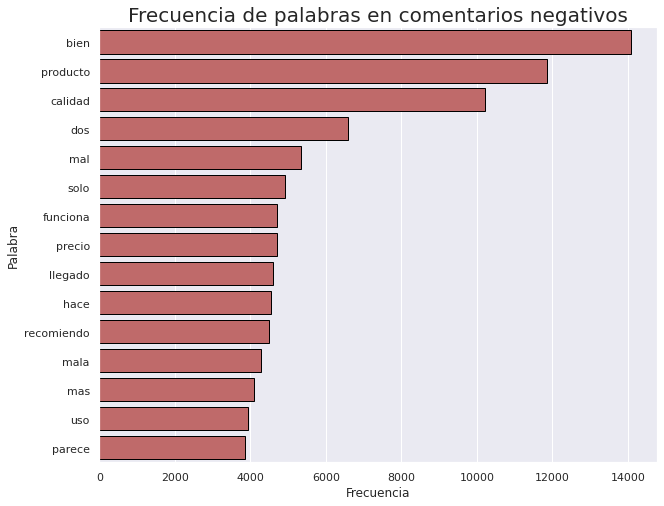

In [ ]:
plt.figure(figsize = (10,8))
plot = sns.barplot(y  = palabras_negativas.iloc[:15].Palabra, 
                   x = palabras_negativas.iloc[:15].Frecuencia
                   ,color='indianred', edgecolor ='black' )
for item in plot.get_xticklabels():
    item.set_rotation(0)
plt.title('Frecuencia de palabras en comentarios negativos', fontsize=20)
plt.show()

## 2- Stemming

In [ ]:
data.head()

In [ ]:
data_stem = pd.concat([data.review_body,data.stars],axis=1)

In [ ]:
data_stem

In [ ]:
import re
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [ ]:
comentario_list=[]
for comentario in data_stem.review_body:
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    comentario=re.sub("[^a-zA-Z]"," ",str(comentario))
    # Pasamos todo a minúsculas
    comentario=comentario.lower()
    # Tokenizamos para separar las palabras del titular
    comentario=nltk.word_tokenize(comentario)
    # Eliminamos las palabras de menos de 3 letras
    comentario= [palabra for palabra in comentario if len(palabra)>3]
    # Sacamos las Stopwords
    comentario = [palabra for palabra in comentario if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    comentario=[stemmer.stem(palabra) for palabra in comentario]
    # Por ultimo volvemos a unir el titular
    comentario=" ".join(comentario)
    
    # Vamos armando una lista con todos los titulares
    comentario_list.append(comentario)
    #dataset["titular_normalizado"] = titular_list


In [ ]:
data_stem["comentarios_stem"] = comentario_list
data_stem.head()

In [ ]:
data_stem1= pd.concat([data_stem.stars,data_stem.comentarios_stem],axis=1)
data_stem1.head()

In [ ]:
index_random = np.random.randint(0,high = data_stem1.shape[0])
comentario = data_stem1.iloc[index_random].comentarios_stem
estrella = data_stem1.iloc[index_random].stars

print(index_random)
print(estrella)
print(comentario)

### **Ahora probamos con SnowballStemmer**

In [ ]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [ ]:
data.head()

In [ ]:
comentario_list=[]
for comentario in data_stem.review_body:
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    comentario=re.sub("[^a-zA-Z]"," ",str(comentario))
    # Pasamos todo a minúsculas
    comentario=comentario.lower()
    # Tokenizamos para separar las palabras del titular
    comentario=nltk.word_tokenize(comentario)
    # Eliminamos las palabras de menos de 3 letras
    comentario= [palabra for palabra in comentario if len(palabra)>3]
    # Sacamos las Stopwords
    comentario = [palabra for palabra in comentario if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    comentario=[stemmer.stem(palabra) for palabra in comentario]
    # Por ultimo volvemos a unir el titular
    comentario=" ".join(comentario)
    
    # Vamos armando una lista con todos los titulares
    comentario_list.append(comentario)
    #dataset["titular_normalizado"] = titular_list


In [ ]:
data_stem["comentarios_stem"] = comentario_list
data_stem.head()

In [ ]:
data_stem2= pd.concat([data_stem.stars,data_stem.comentarios_stem],axis=1)
data_stem2.comentarios_stem[:21]

### **Comparación Normal - Porter - Snowball**

**Normal**

In [ ]:
comentario = data.iloc[199439].review_body
estrella = data.iloc[199439].stars
print(estrella)
print(comentario)

**Porter**

In [ ]:
comentario = data_stem1.iloc[199439].comentarios_stem
estrella = data_stem1.iloc[199439].stars
print(estrella)
print(comentario)

**Snowball**

In [ ]:
index_random = np.random.randint(0,high = data_stem2.shape[0])
comentario = data_stem2.iloc[index_random].comentarios_stem
estrella = data_stem2.iloc[index_random].stars

print(index_random)
print(estrella)
print(comentario)

## 3- Lemmatization

### **1- WordNetLemmatizer**

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_treebank_pos_')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
# Oracion que usaremos como ejemplo
frase = "En la descripción del producto dice que es compatible con HP Pavillion DV6 y no es cierto. No encaja en el hueco. Además al día siguiente compré uno original, hice los trámites para la devolución y un mes y medio más tarde sigo esperando que me recojan el producto."

# Hay que regularizar el texto. Dejar solo letra, pasar a minúsculas y tokenizar:

frase = clean_text_round1(frase)

# Sacamos todo lo que no sean letras
frase = re.sub("[^a-zA-Z]"," ",str(frase))
# Pasamos a minúsculas
frase = frase.lower()
# Tokenizamos
frase_tokens = nltk.word_tokenize(frase)

# Veamos como cambians las palabras al lemmatizar
print("{0:20}{1:20}".format("Word","Lemma"))
for palabra in frase_tokens:
    print ("{0:20}{1:20}".format(palabra,wordnet_lemmatizer.lemmatize(palabra)))

In [ ]:
print(nltk.pos_tag(frase_tokens))

In [ ]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(frase)]
tipo_palabra = [get_wordnet_pos(w) for w in nltk.word_tokenize(frase)]

# Veamos como cambiaron las palabras
print("{0:20}{1:20}{2:20}".format("Palabra:","Tipo:","Lemma:"))
for i in range(len(frase_tokens)):
    print ("{0:20}{1:20}{2:20}".format(frase_tokens[i],tipo_palabra[i],frase_lemma[i]))

### **2- Stanza**

In [ ]:
!pip install stanza


     |████████████████████████████████| 286kB 17.5MB/s 


In [ ]:
import stanza
stanza.download("es")
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')
texto_pablito = "En la descripción del producto dice que es compatible con HP Pavillion DV6 y no es cierto. No encaja en el hueco. Además al día siguiente compré uno original, hice los trámites para la devolución y un mes y medio más tarde sigo esperando que me recojan el producto."
doc = nlp(texto_pablito)
print(*[f'Palabra: {word.text+" "}\tLemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')

2021-04-29 21:59:31 INFO: Downloading default packages for language: es (Spanish)...
2021-04-29 22:01:23 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-04-29 22:01:24 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2021-04-29 22:01:24 INFO: Use device: cpu
2021-04-29 22:01:24 INFO: Loading: tokenize
2021-04-29 22:01:24 INFO: Loading: mwt
2021-04-29 22:01:24 INFO: Loading: pos
2021-04-29 22:01:24 INFO: Loading: lemma
2021-04-29 22:01:24 INFO: Done loading processors!


Palabra: En 	Lemma: en
Palabra: la 	Lemma: el
Palabra: descripción 	Lemma: descripción
Palabra: del 	Lemma: del
Palabra: producto 	Lemma: producto
Palabra: dice 	Lemma: decir
Palabra: que 	Lemma: que
Palabra: es 	Lemma: ser
Palabra: compatible 	Lemma: compatible
Palabra: con 	Lemma: con
Palabra: HP 	Lemma: HP
Palabra: Pavillion 	Lemma: Pavillion
Palabra: DV6 	Lemma: DV6
Palabra: y 	Lemma: y
Palabra: no 	Lemma: no
Palabra: es 	Lemma: ser
Palabra: cierto 	Lemma: cierto
Palabra: . 	Lemma: .
Palabra: No 	Lemma: no
Palabra: encaja 	Lemma: encajar
Palabra: en 	Lemma: en
Palabra: el 	Lemma: el
Palabra: hueco 	Lemma: hueco
Palabra: . 	Lemma: .
Palabra: Además 	Lemma: además
Palabra: al 	Lemma: al
Palabra: día 	Lemma: día
Palabra: siguiente 	Lemma: siguiente
Palabra: compré 	Lemma: comprar
Palabra: uno 	Lemma: uno
Palabra: original 	Lemma: original
Palabra: , 	Lemma: ,
Palabra: hice 	Lemma: hacer
Palabra: los 	Lemma: el
Palabra: trámites 	Lemma: trámite
Palabra: para 	Lemma: para
Palabra: la 	L

In [ ]:
# Oracion que usaremos como ejemplo
frase = "En la descripción del producto dice que es compatible con HP Pavillion DV6 y no es cierto. No encaja en el hueco. Además al día siguiente compré uno original, hice los trámites para la devolución y un mes y medio más tarde sigo esperando que me recojan el producto."

# Hay que regularizar el texto. Dejar solo letra, pasar a minúsculas y tokenizar:

frase = clean_text_round1(frase)

# Sacamos todo lo que no sean letras
frase = re.sub("[^a-zA-Z]"," ",str(frase))
# Pasamos a minúsculas
frase = frase.lower()
# Tokenizamos
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')
doc = nlp(frase)
# Veamos como cambians las palabras al lemmatizar
print("{0:20}{1:20}".format("Word","Lemma"))
for palabra in doc.sentences:
    print ("{0:20}{1:20}".format(palabra,wordnet_lemmatizer.lemmatize(palabra)))

# 3 - Vectorización

## 1er Sprint

In [ ]:
comentarios = data['review_body'].to_frame('review_body')
comentarios.head()

,review_body
0,Nada bueno se me fue ka pantalla en menos de 8...
1,"Horrible, nos tuvimos que comprar otro porque ..."
2,Te obligan a comprar dos unidades y te llega s...
3,"No entro en descalificar al vendedor, solo pue..."
4,Llega tarde y co la talla equivocada


In [ ]:
filtrar = ['es','el','muy','la','los','lo','me','si','no','se']
resenas = []
for i in range(comentarios.shape[0]):
  comentario = comentarios.iloc[i].review_body
  comentario = clean_text_round1(comentario)
  comentario = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(comentario)
  comentario = [word for word in comentario if word not in stopwords]
  comentario = [word for word in comentario if word not in filtrar]

  # Por ultimo volvemos a unir el titular
  comentario=" ".join(comentario)

  resenas.append(comentario)

In [ ]:
comentarios['filtro1'] = resenas
comentarios.tail()

### Vectorizamos

In [ ]:
#Elegimos los comentarios en el filtrado anterior.
comentarios= list(comentarios['filtro1'].values)
puntaje= data['stars'].values


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

max_features = 1000

count_vec= CountVectorizer(max_features = max_features)

In [ ]:
matriz_comentarios = count_vec.fit_transform(comentarios)

# Tomamos las palabras
all_words = count_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

## 2do Sprint


# 4 - Modelos

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 1er Sprint

### Train Test

In [ ]:
x = matriz_comentarios.toarray()
y = puntaje

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

Definimos una función que nos permita plotear los resultados en una matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    stars=['1','2','3','4','5']
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(10,10))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(stars)
    ax.set_yticklabels(stars)
    plt.show()

    return

### Naive Bayes

In [ ]:
data.memory

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
print("acc : ", nb.score(xtest,ytest))

acc :  0.3881


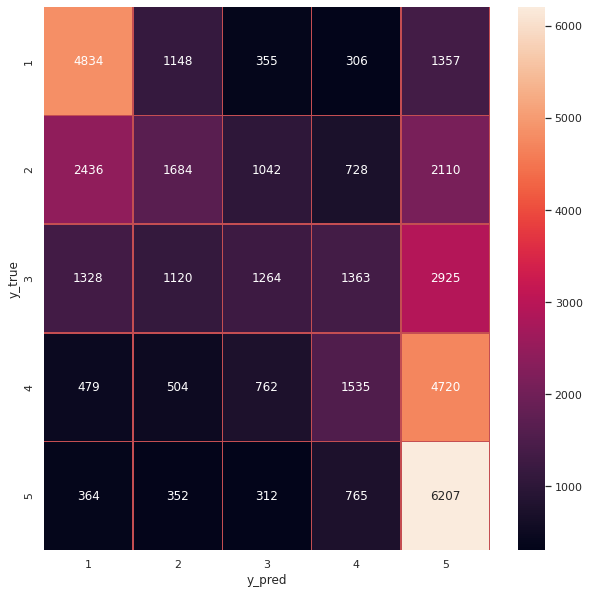

In [ ]:
y_pred=nb.predict(xtest)
confusion(ytest,y_pred)

In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.51      0.60      0.55      8000
           2       0.35      0.21      0.26      8000
           3       0.34      0.16      0.22      8000
           4       0.33      0.19      0.24      8000
           5       0.36      0.78      0.49      8000

    accuracy                           0.39     40000
   macro avg       0.38      0.39      0.35     40000
weighted avg       0.38      0.39      0.35     40000



Como es de esperarse: Los extremos tienen "buenos" accuracys, y descienden 

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))

acc:  0.42275


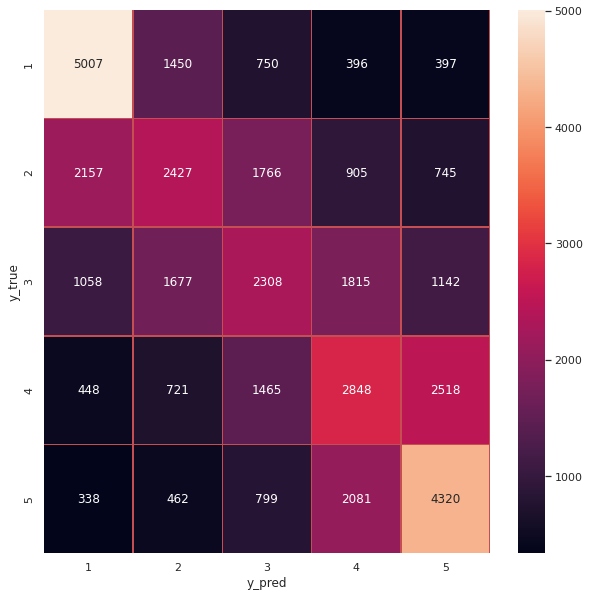

In [ ]:
y_pred=rf.predict(xtest)
confusion(ytest,y_pred)

In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.56      0.63      0.59      8000
           2       0.36      0.30      0.33      8000
           3       0.33      0.29      0.31      8000
           4       0.35      0.36      0.36      8000
           5       0.47      0.54      0.50      8000

    accuracy                           0.42     40000
   macro avg       0.41      0.42      0.42     40000
weighted avg       0.41      0.42      0.42     40000



## 2do Sprint
